In [ ]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [2]:
# create helper function to load the data from jsonl files
def load_jsonl(file_path: str) -> list[dict]:
    """
    Load a jsonl file and return a list of dictionaries.
    """
    data = []
    with open(file_path, "r") as f:
        for line in f:
            item = json.loads(line)
            # keep only the "conversation" and "target_agent" fields
            item = {
                "conversation": item["conversation"],
                "target_agent": item["target_agent"],
            }
            data.append(item)
    return data

In [3]:
# load the training and testing data
train_dataset = load_jsonl("../data_sets/triage-training-proofread.jsonl")
test_dataset = load_jsonl("../data_sets/triage-testing-proofread.jsonl")

In [5]:
# compute train and test embeddings
st = SentenceTransformer("all-MiniLM-L12-v2")
train_embeddings = st.encode([item["conversation"] for item in train_dataset])
test_embeddings = st.encode([item["conversation"] for item in test_dataset])

In [6]:
# compute tsne of the training embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_embeddings)
test_tsne = tsne.fit_transform(test_embeddings)

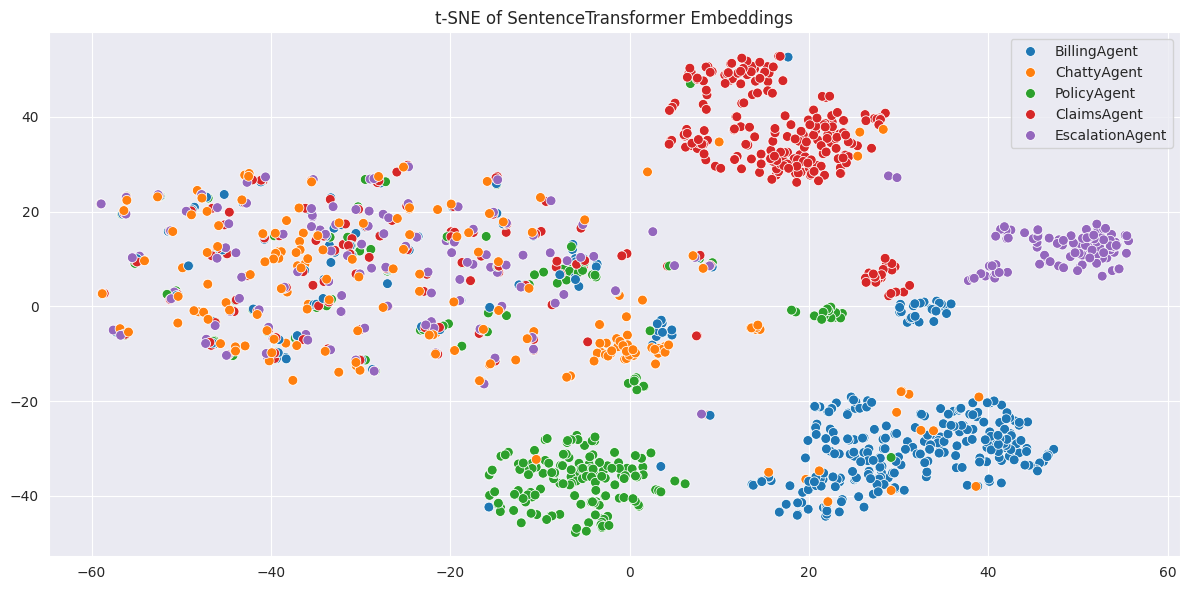

In [57]:
# plot tsne of the training embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_tsne[:, 0],
    y=train_tsne[:, 1],
    hue=[item["target_agent"] for item in train_dataset],
    s=50,
)
plt.title("t-SNE of SentenceTransformer Embeddings")
# save the tight plot using transparent background
plt.tight_layout()
# save the plot with transparent background
plt.savefig("tsne_training_embeddings.png", transparent=True)

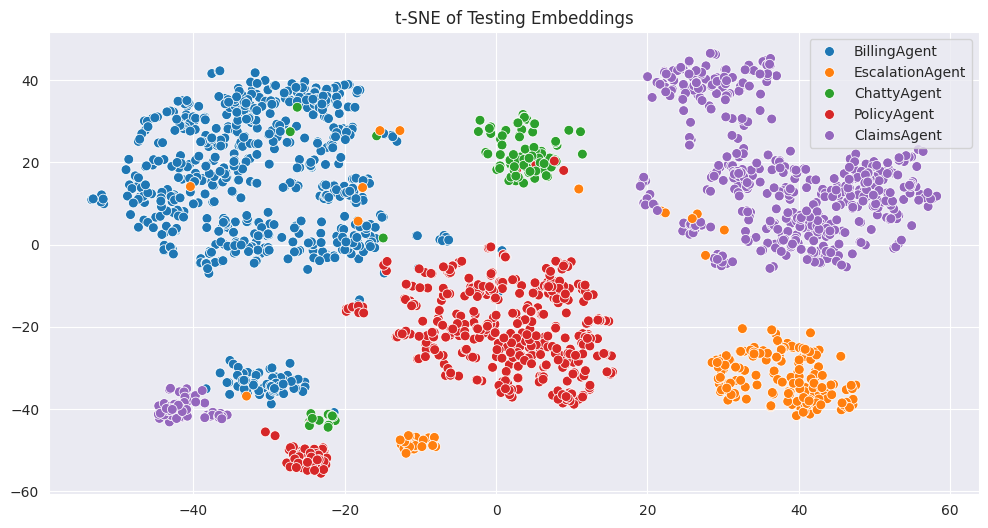

In [8]:
# plot tsne of the testing embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=test_tsne[:, 0],
    y=test_tsne[:, 1],
    hue=[item["target_agent"] for item in test_dataset],
    s=50,
)
plt.title("t-SNE of Testing Embeddings")
# save the plot
plt.savefig("tsne_testing_embeddings.png")

# Attention Net representation visualization

In [9]:
from agents.triage.attention_net.attention_based_classifier import (
    AttentionBasedClassifier,
    AttentionBasedClassifierWrapper,
)

# load attention net checkpoint
model = AttentionBasedClassifier(
    embedding_dim=384, hidden_dims=(256, 128), n_classes=5, dropout=0.25
)
state_dict = torch.load("../model_checkpoints/attention_net.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# create wrapper
model = AttentionBasedClassifierWrapper(model)

In [10]:
# compute attention_pooled embeddings for the training set
train_attention_embeddings = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        conversation = item["conversation"]
        # split conversation by new line
        chat_history = conversation.split("\n")
        _, _, attention_pooled_embedding = model(
            chat_history, return_attention_weights=True
        )
        train_attention_embeddings.append(attention_pooled_embedding[0])
# convert to numpy
train_attention_embeddings = torch.stack(train_attention_embeddings).cpu().numpy()

100%|██████████| 1572/1572 [00:20<00:00, 75.25it/s]


In [11]:
# compute attention_pooled embeddings for the test set
test_attention_embeddings = []
with torch.no_grad():
    for item in tqdm(test_dataset):
        conversation = item["conversation"]
        # split conversation by new line
        chat_history = conversation.split("\n")
        _, _, attention_pooled_embedding = model(
            chat_history, return_attention_weights=True
        )
        test_attention_embeddings.append(attention_pooled_embedding[0])
# convert to numpy
test_attention_embeddings = torch.stack(test_attention_embeddings).cpu().numpy()

100%|██████████| 2219/2219 [00:30<00:00, 72.02it/s]


In [12]:
# compute tsne of the attention pooled embeddings
train_attention_tsne = tsne.fit_transform(train_attention_embeddings)
test_attention_tsne = tsne.fit_transform(test_attention_embeddings)

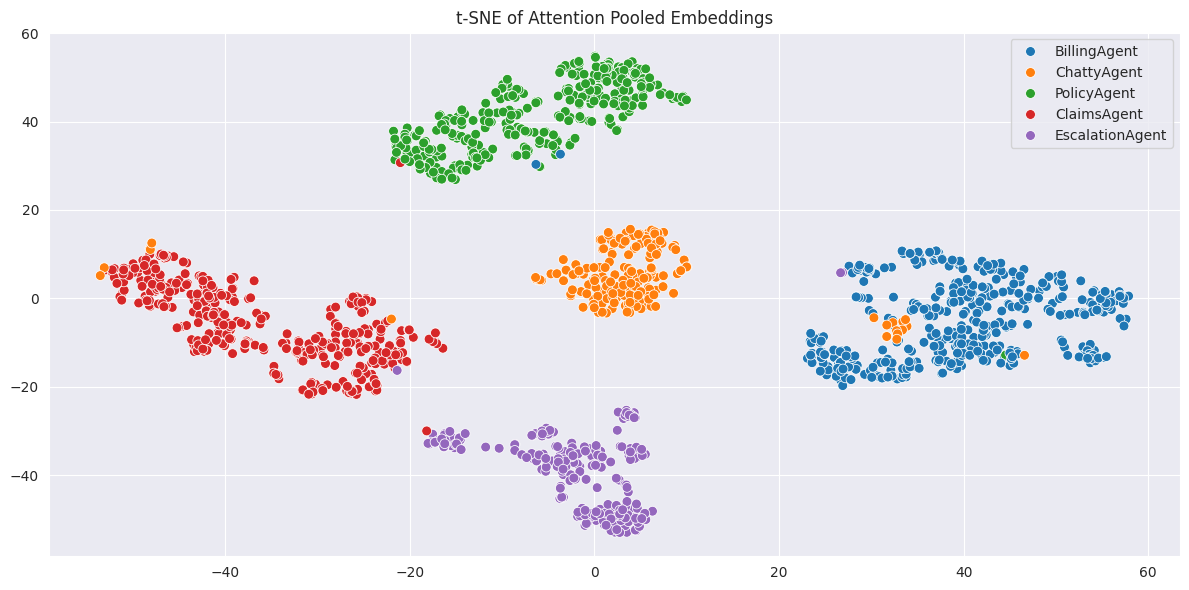

In [59]:
# plot tsne of the attention pooled embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_attention_tsne[:, 0],
    y=train_attention_tsne[:, 1],
    hue=[item["target_agent"] for item in train_dataset],
    s=50,
)
plt.title("t-SNE of Attention Pooled Embeddings")
# save the plot
plt.tight_layout()
# save with transparent background
plt.savefig("tsne_attention_pooled_training_embeddings.png", transparent=True)

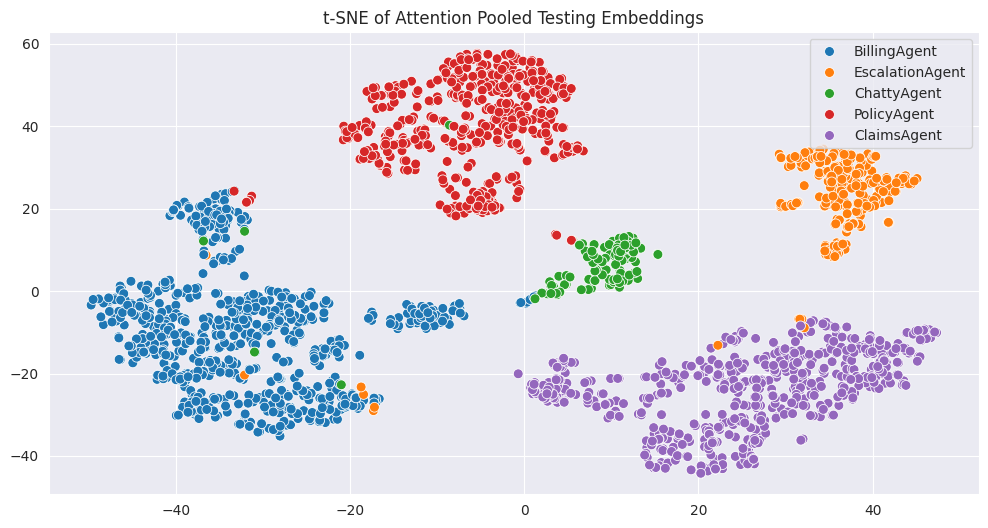

In [14]:
# plot tsne of the attention pooled embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=test_attention_tsne[:, 0],
    y=test_attention_tsne[:, 1],
    hue=[item["target_agent"] for item in test_dataset],
    s=50,
)
plt.title("t-SNE of Attention Pooled Testing Embeddings")
# save the plot
plt.savefig("tsne_attention_pooled_testing_embeddings.png")

### Comparison of the baseline model and the attention net

In [17]:
from agents.triage.baseline_model.few_shots_classifier import FewShotsClassifier

# load baseline model
baseline = FewShotsClassifier.load("../model_checkpoints/fewshot_baseline_n_all.pkl")

In [52]:
from agents.triage.models import TargetAgent

# test chat history
chat_history = [
    "User: Hi, what's your favorite color?",
    "ChattyAgent: Hello! I'm just a chatbot, so I don't have a favourite colour, but I can help you with insurance questions!",
    "User: That's ok, just wanted to chat a bit.",
    "ChattyAgent: Sure, I'm here to chat! What would you like to talk about?",
    "User: I have a question about my policy. What's the coverage for my car insurance?",
    "PolicyAgent: Sure, I can help you with that. Can you please provide me with your policy number?",
    "User: It's AR234543.",
]
labels = {
    0: TargetAgent.BillingAgent,
    1: TargetAgent.PolicyAgent,
    2: TargetAgent.ClaimsAgent,
    3: TargetAgent.EscalationAgent,
    4: TargetAgent.ChattyAgent,
}

In [33]:
# get baseline model prediction
chat = "\n".join(chat_history)
baseline_probabs = baseline([chat])[0]
print("Baseline model probabilities:", baseline_probabs)
# get baseline model prediction label
baseline_label = labels[baseline_probabs.argmax()]
print("Baseline model predicted label:", baseline_label)

Baseline model probabilities: [0.02244796 0.16206189 0.01409842 0.00812999 0.79326174]
Baseline model predicted label: TargetAgent.ChattyAgent


Baseline model incorrectly predicts the label as `ChattyAgent`, while the correct label is `PolicyAgent`. Let's see how the attention net performs on the same chat history.

In [53]:
# get attention net prediction
probs, _, attention_weights, _ = model.predict_probab(chat_history, return_logits=True)
probs = probs[0].cpu().numpy()
attention_weights = attention_weights[0].cpu().numpy()
print("Attention net probabilities:", probs)
# get attention net prediction label
attention_label = labels[probs.argmax()]
print("Attention net predicted label:", attention_label)

Attention net probabilities: [1.1443287e-03 9.9712282e-01 1.6524213e-04 1.6847553e-04 1.3992077e-03]
Attention net predicted label: TargetAgent.PolicyAgent


Attention net correctly predicts the label as `PolicyAgent`. Let's visualize the attention weights.

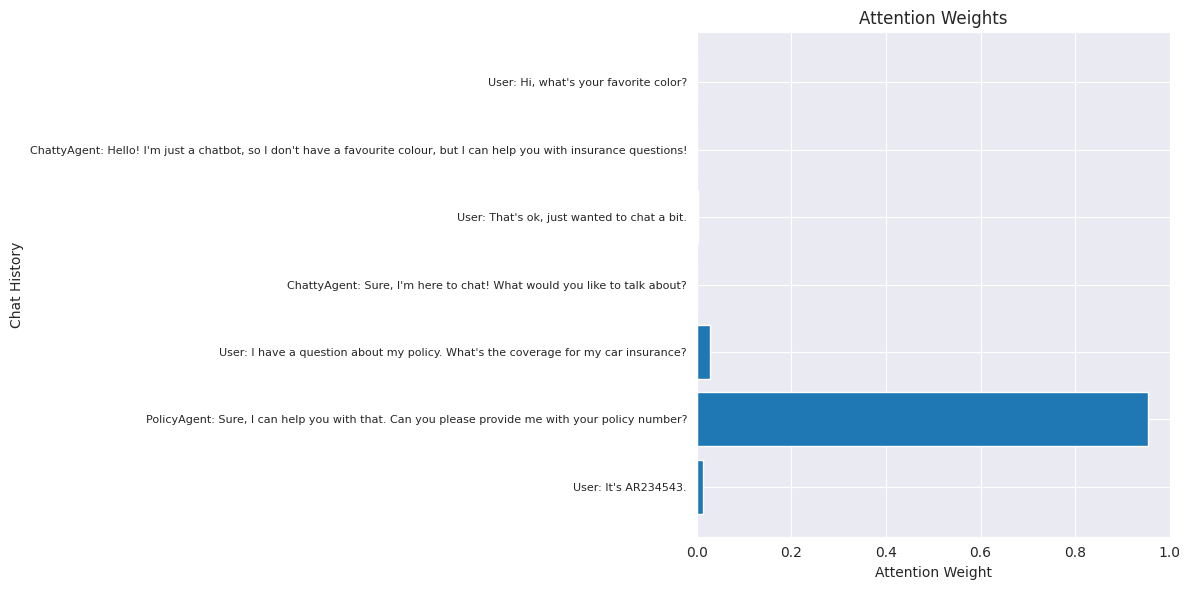

In [54]:
# plot attention weights
plt.figure(figsize=(12, 6))
plt.barh(range(len(attention_weights)), attention_weights)
plt.gca().invert_yaxis()
plt.yticks(range(len(chat_history)), chat_history, fontsize=8)
plt.title("Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Chat History")
plt.tight_layout()
# plt.show()
# save the plot
plt.savefig("attention_weights.png")

In [47]:
# let's test another example
chat_history2 = [
    "User: Yo! What's up with my claim status? Been waiting for 3 weeks now with no updates.",
    "ClaimsAgent: Hi there! I understand your frustration. Let me check the status of your claim for you. What's your customer ID?",
    "User: It's 312414213.",
    "ClaimsAgent: Thank you for providing your customer ID. I see that your claim is still under review. I apologize for the delay, but we are working hard to process it as quickly as possible. Is there anything else I can assist you with?",
    "User: What's the estimated time for processing?",
    "ClaimsAgent: The estimated time for processing is usually around 2-3 weeks, but it can vary depending on the complexity of the claim. I apologize for the inconvenience and appreciate your patience.",
    "User: Ok, thanks for the info.",
    "ClaimsAgent: Is there anything else I can help you with?",
    "User: Let's talk about something else. How's the weather today?",
]

In [48]:
chat = "\n".join(chat_history2)
baseline_probabs = baseline([chat])[0]
print("Baseline model probabilities:", baseline_probabs)
# get baseline model prediction label
baseline_label = labels[baseline_probabs.argmax()]
print("Baseline model predicted label:", baseline_label)

Baseline model probabilities: [0.01602522 0.00331363 0.85602886 0.09680547 0.02782681]
Baseline model predicted label: TargetAgent.ClaimsAgent


Baseline model incorrectly predicts the `ClaimsAgent`. The correct answer is `ChattyAgent`, since the user is not asking about insurance, but rather about the weather. Let's see how the attention net performs on the same chat history.

In [49]:
# get attention net prediction
probs, _, attention_weights, _ = model.predict_probab(chat_history2, return_logits=True)
probs = probs[0].cpu().numpy()
attention_weights = attention_weights[0].cpu().numpy()
print("Attention net probabilities:", probs)
# get attention net prediction label
attention_label = labels[probs.argmax()]
print("Attention net predicted label:", attention_label)

Attention net probabilities: [8.2889735e-04 5.1455892e-04 8.5206699e-01 4.6478838e-02 1.0011077e-01]
Attention net predicted label: TargetAgent.ClaimsAgent


/tmp/ipykernel_7642/15624685.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


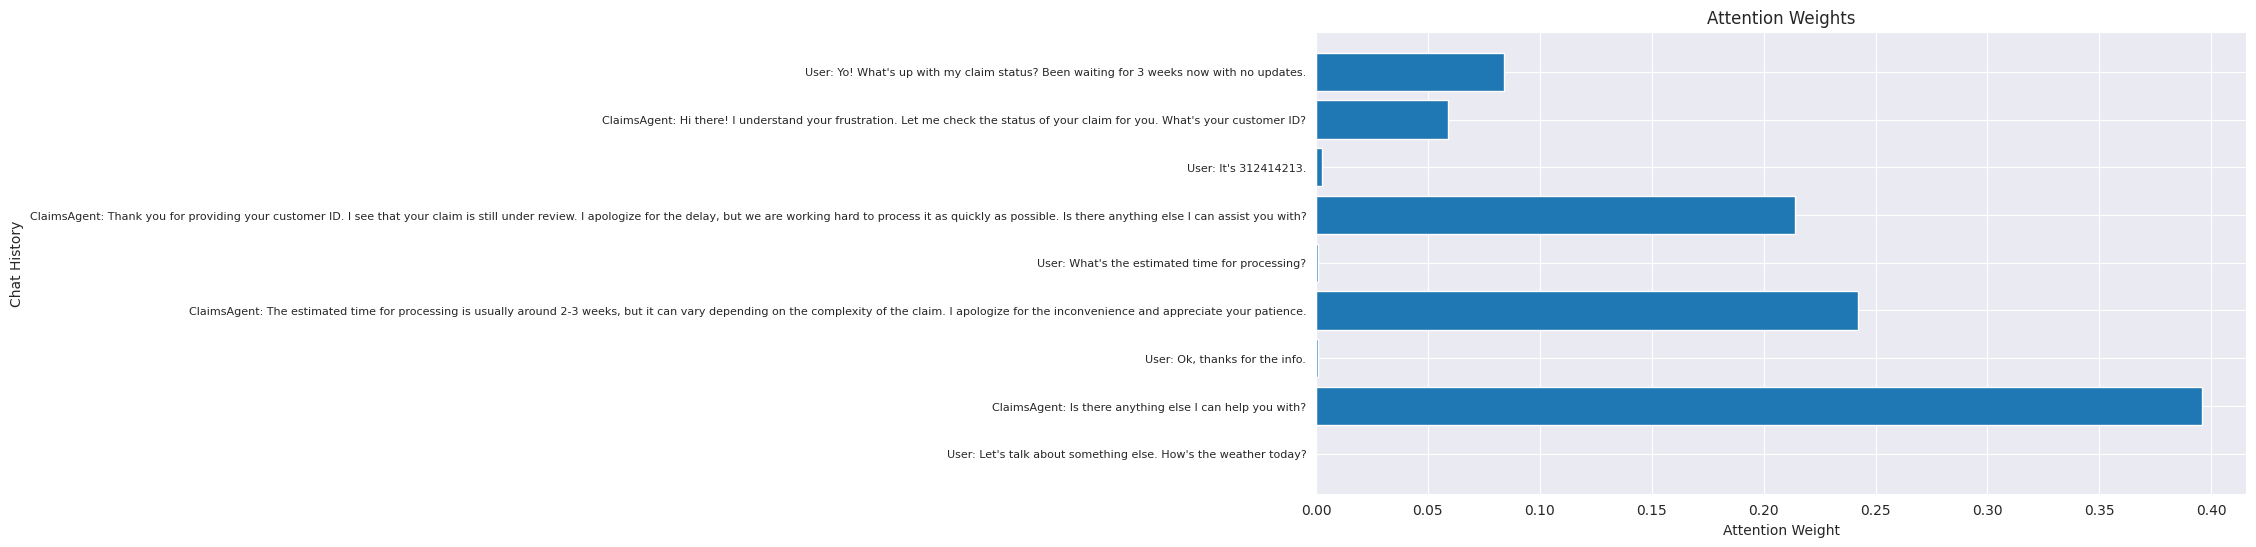

In [51]:
# plot attention weights
plt.figure(figsize=(12, 6))
plt.barh(range(len(attention_weights)), attention_weights)
plt.gca().invert_yaxis()
plt.yticks(range(len(chat_history2)), chat_history2, fontsize=8)
plt.title("Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Chat History")
plt.tight_layout()
# plt.show()
# save the plot
plt.savefig("attention_weights.png")

In this case the attention net is also incorrect and predicts `ClaimsAgent`, while the correct label is `ChattyAgent`.  We can see that the last message which determines the label has a very low attention weight, which means that the model is not paying attention to it. We can enforce the last message prior more by adding positional encodings to the input embeddings of the attention net. This way the model will learn to pay more attention to the last message in the chat history. 